In [1]:
import numpy as np
#
# The function in this file follow closely after the MATLAB scripts
# written by Alessandro Foi and Markku Makitalo - Tampere University
# of Technology - 2011-2012
#
#    http://www.cs.tut.fi/~foi/invansc/
#
# that accompanies their paper:
#
#    Reference: M. Makitalo and A. Foi, "Optimal inversion of the
#    generalized Anscombe transformation for Poisson-Gaussian noise",
#    IEEE Trans. Image Process., doi:10.1109/TIP.2012.2202675


#-------- Variance stabilizing transforms -----------

def anscombe(x):
    '''
    Compute the anscombe variance stabilizing transform.
      the input   x   is noisy Poisson-distributed data
      the output  fx  has variance approximately equal to 1.
    Reference: Anscombe, F. J. (1948), "The transformation of Poisson,
    binomial and negative-binomial data", Biometrika 35 (3-4): 246-254
    '''
    return 2.0*np.sqrt(x + 3.0/8.0)

def inverse_anscombe(z):
    '''
    Compute the inverse transform using an approximation of the exact
    unbiased inverse.
    Reference: Makitalo, M., & Foi, A. (2011). A closed-form
    approximation of the exact unbiased inverse of the Anscombe
    variance-stabilizing transformation. Image Processing.
    '''
    #return (z/2.0)**2 - 3.0/8.0
    return (1.0/4.0 * np.power(z, 2) +
            1.0/4.0 * np.sqrt(3.0/2.0) * np.power(z, -1.0) -
            11.0/8.0 * np.power(z, -2.0) + 
            5.0/8.0 * np.sqrt(3.0/2.0) * np.power(z, -3.0) - 1.0 / 8.0)

def generalized_anscombe(x, mu, sigma, gain=1.0):
    '''
    Compute the generalized anscombe variance stabilizing transform,
    which assumes that the data provided to it is a mixture of poisson
    and gaussian noise.
    The input signal  z  is assumed to follow the Poisson-Gaussian noise model
        x = gain * p + n
    where gain is the camera gain and mu and sigma are the read noise
    mean and standard deviation.
    We assume that x contains only positive values.  Values that are
    less than or equal to 0 are ignored by the transform.
    Note, this transform will show some bias for counts less than
    about 20.
    '''
    y = gain*x + (gain**2)*3.0/8.0 + sigma**2 - gain*mu

    # Clamp to zero before taking the square root.
    return (2.0/gain)*np.sqrt(np.maximum(y, 0.0))

def inverse_generalized_anscombe(x, mu, sigma, gain=1.0):
    '''
    Applies the closed-form approximation of the exact unbiased
    inverse of Generalized Anscombe variance-stabilizing
    transformation.
    The input signal x is transform back into a Poisson random variable
    based on the assumption that the original signal from which it was
    derived follows the Poisson-Gaussian noise model:
        x = gain * p + n
    where gain is the camera gain and mu and sigma are the read noise
    mean and standard deviation.
    Roference: M. Makitalo and A. Foi, "Optimal inversion of the
    generalized Anscombe transformation for Poisson-Gaussian noise",
    IEEE Trans. Image Process., doi:10.1109/TIP.2012.2202675
    '''
    test = np.maximum(x, 1.0)
    exact_inverse = ( np.power(test/2.0, 2.0) +
                      1.0/4.0 * np.sqrt(3.0/2.0)*np.power(test, -1.0) -
                      11.0/8.0 * np.power(test, -2.0) +
                      5.0/8.0 * np.sqrt(3.0/2.0) * np.power(test, -3.0) -
                      1.0/8.0 - np.power(sigma, 2) )
    exact_inverse = np.maximum(0.0, exact_inverse)
    exact_inverse *= gain
    exact_inverse += mu
    exact_inverse[np.where(exact_inverse != exact_inverse)] = 0.0
    return exact_inverse

#def inverse_generalized_anscombe(y,mu,sigma,gain=1.0):
#    return (1.0/gain)*(gain*y/2.0)**2 - gain*3.0/8.0 - (sigma**2)/gain + mu

In [2]:
from bm3d import bm3d, BM3DProfile
import numpy as np
import scipy.misc
from matplotlib import pyplot as plt
from tifffile import imread, imsave

In [4]:
noisy = imread('../../../experiments/fairSim/2020-07-27/Zeiss/p-2/Zeiss_Mito_600nm_crop_Poisson-n-2.tif').astype(np.float32)

clean = imread('../../../experiments/fairSim/2020-07-27/Zeiss/Zeiss_Mito_600nm_crop.tif').astype(np.float32)
print(noisy.shape)
print(clean.shape)


(5, 25, 512, 512)
(5, 25, 512, 512)


In [5]:
offset=100
from tqdm import tqdm
mses=[]
denoisedImgs=[]
bestMSE = None
bestImg = None
bestSig= None

for s in range(40):
    sig = (s+1)*2.5
    #denoised=noisy.copy()
    j=0
    #for i in range(5):
    i=0
#        print(i,j)

    img=noisy[i,j,...]
    cl= clean[i,j,...]

        
    ans=anscombe(img-offset)
    denoised = inverse_anscombe (bm3d (ans,sig)) + offset
    
        
    mse = np.mean((cl-denoised)**2)
    mses.append(mse)
    denoisedImgs.append(denoised.copy())
    
    if bestMSE is None or (mse<bestMSE):
        bestImg = denoised.copy()
        bestMSE = mse
        bestSig = sig
    print (sig, bestSig, mse)

        

2.5 2.5 107942.46341023709
5.0 2.5 2.9926105780802785e+19
7.5 2.5 2.3220396081209364e+18
10.0 2.5 446914174188338.5
12.5 12.5 29164.033008694212
15.0 15.0 16774.726382600096
17.5 17.5 14184.79448741705
20.0 20.0 13833.051713533489
22.5 20.0 13878.748006253958
25.0 20.0 14037.967594909665
27.5 20.0 14235.347268644196
30.0 20.0 14463.020045177038
32.5 20.0 14708.921692292502
35.0 20.0 14969.590599235578
37.5 20.0 15239.645611897698
40.0 20.0 15531.946018223724
42.5 20.0 15838.328320265611
45.0 20.0 16141.940040079078
47.5 20.0 16469.089966401974
50.0 20.0 16801.478142742137
52.5 20.0 17137.0701377393
55.0 20.0 17481.54398309644
57.5 20.0 17839.404384190013
60.0 20.0 18200.845141999136
62.5 20.0 18566.720850223734
65.0 20.0 18946.50950016302
67.5 20.0 19327.78182175712
70.0 20.0 19714.653372643228
72.5 20.0 20101.64713478506
75.0 20.0 20497.881523186552
77.5 20.0 20907.630021704063
80.0 20.0 21316.00967436311
82.5 20.0 21725.25321607474
85.0 20.0 22140.463962004327
87.5 20.0 22554.9460378

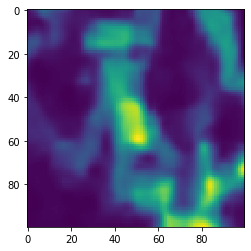

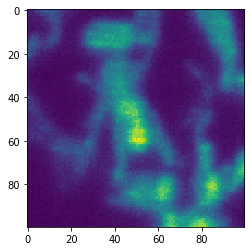

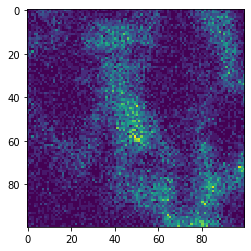

In [6]:
plt.imshow(denoisedImgs[11][100:200,100:200])
plt.show()
plt.imshow(cl[100:200,100:200])
plt.show()
plt.imshow(img[100:200,100:200])


In [7]:
offset=100
from tqdm import tqdm
denoised=noisy.copy()

for j in tqdm(range(25)):
    for i in range(5):
        img=noisy[i,j,...]
        cl= clean[i,j,...]

        sig = bestSig

        ans=anscombe(img-offset)
        denoisedImg = inverse_anscombe (bm3d (ans,sig)) + offset
        denoised[i,j,...] = denoisedImg
    


imsave('../../../experiments/fairSim/2020-07-27/Zeiss/p-2/n-2_VST-BM3D.tif', denoised)
        

100%|██████████| 25/25 [1:08:09<00:00, 163.57s/it]
